# EMR Notebook SageMaker Custom Abalone Ring Estimator

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Load the Data](#Load-the-Data)
4. [Train the Model](#Train-the-Model)
5. [Inference Results](#Inference-Results)
7. [Wrap-Up](#Wrap-Up)

## Introduction

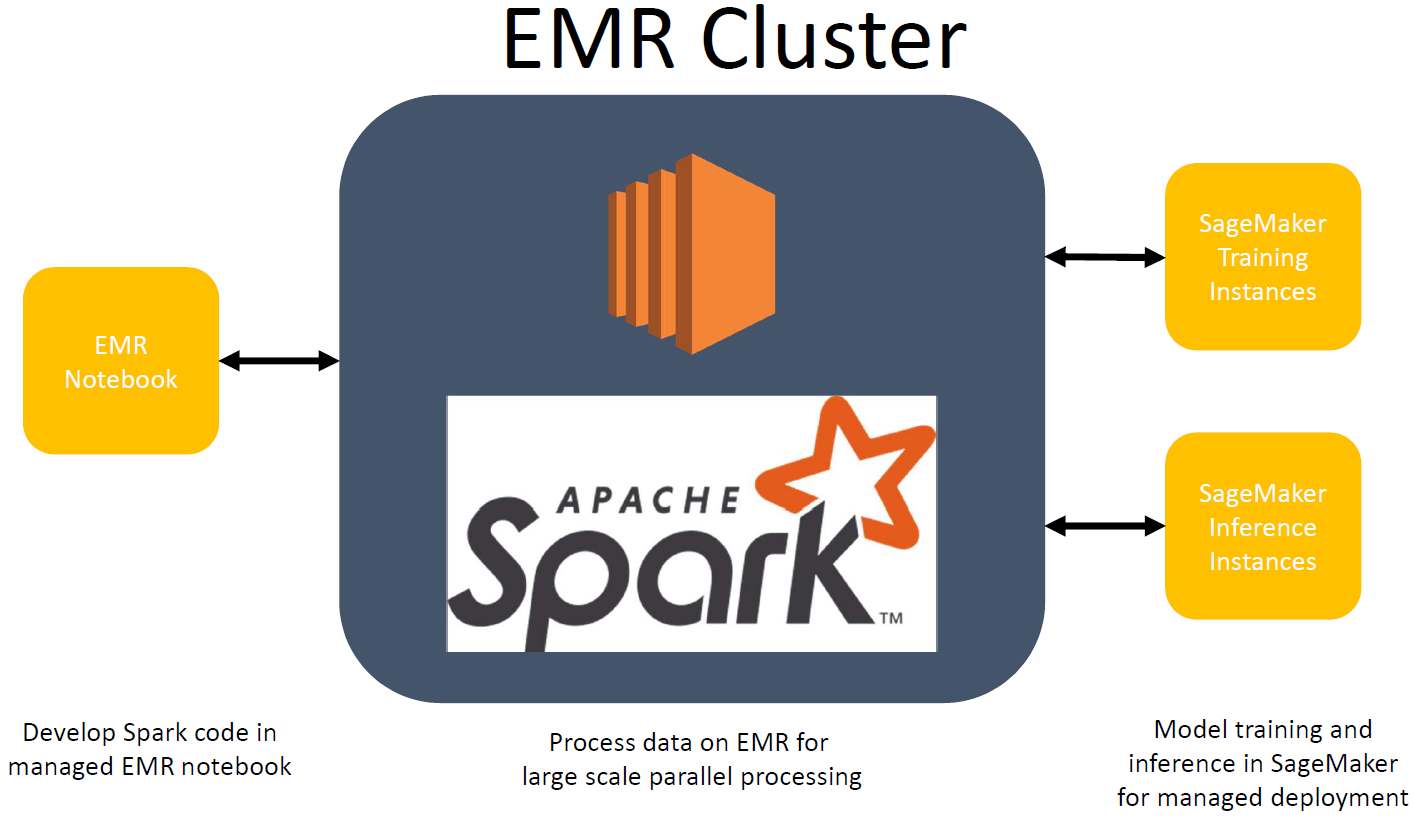

## Setup
First we need to install the Python packages that we'll need throughout the notebook. EMR notebooks come with a default set of libraries for data processing. You can see which libraries are installed on the notebook by calling the list_packages() function. 

In [ ]:
sc.list_packages()

To comunicate with Sagemaker we will need to install notebook scoped libraries in our environment. These libraries are available only during the notebook session. After the session ends, the libraries are deleted. 

We install [boto3 (the AWS Python 3 SDK)](https://aws.amazon.com/sdk-for-python/) and the [high level SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/). 

In [ ]:
sc.install_pypi_package("boto3");
sc.install_pypi_package('sagemaker');

In [ ]:
#define user specific parameters
region = 'us-west-2'
source_bucket = 's3a://emr-lab-income-dataset/'
#The IAM role that SageMaker will use to access other AWS resources.
sagemaker_execution_role = 'arn:aws:iam::883624334343:role/service-role/AmazonSageMaker-ExecutionRole-20190906T093404'
#The number of EMR nodes to process the data.
num_workers = 2

In [ ]:
import boto3
import sagemaker

#We initiate a session for the boto3 and sagemaker APIs. The session includes information necessary to call the
#AWS APIS, such as AWS credentials and default AWS region. For this lab we will leverage the IAM role attached to
#the EMR notebook, so we only need to provide a region.
boto_sess = boto3.Session(region_name=region)
sage_sdk_session = sagemaker.Session(boto_session=boto_sess)
bucket = sage_sdk_session.default_bucket()

print('A SageMaker session was initiated! You are using {} as your S3 bucket for intermediate files.'.format(bucket))

## Load the Data

We will use the public abalone data set from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone)
to train and test our model.

   Given in the dataset is the attribute name, attribute type, the measurement unit and a
   brief description.  The number of rings is the value to predict: either
   as a continuous value or as a classification problem.
   
   The age of an abalone is the number of rings in the shell + 1.5 years. Without a model researchers must cut through the abalone shell
   and use a microscope to count the rings. Using a model to predict rings eliminates this time consuming process.

	Name			Data Type		Meas.	Description
	----			---------		-----	-----------
	Rings			integer					+1.5 gives the age in years
	Length			continuous		mm		Longest shell measurement
	Diameter		continuous		mm		perpendicular to length
	Height			continuous		mm		with meat in shell
	Whole weight	continuous		grams	whole abalone
	Shucked weight	continuous		grams	weight of meat
	Viscera weight	continuous		grams	gut weight (after bleeding)
	Shell weight	continuous		grams	after being dried
	Male			integer			1/0 	1 encodes true, 0 false
	Female			integer			1/0 	1 encodes true, 0 false
	Infant			integer			1/0 	1 encodes true, 0 false

In [ ]:
#Download down dataset from the S3
abalone_data = spark.read.load(source_bucket + 'clean/', format='csv', inferSchema=True, header=True).repartition(num_workers)
abalona_data.show(n=5)

In [ ]:
#Split the dataframe in to training and validation data.
#The training will be used to refine our model.
#The test data will be used to measure the model's accuracy.
train_data, test_data = abalone_data.randomSplit([.75,.25])

s3_train_emr = 's3a://'+ bucket + '/train/'
s3_test_emr = 's3a://'+ bucket + '/test/'
data_format = 'csv'

#Save the data in to S3 for training by SageMaker
train_data.write.save(s3_train_emr, format=data_format, mode='overwrite')
test_data.write.save(s3_test_emr, format=data_format, mode='overwrite')

print('Training dataset saved in {} format to {}!'.format(data_format, s3_train_emr))
print('Testing dataset saved in {} format to {}!'.format(data_format, s3_test_emr))

## Train the Model
SageMaker contains several common built-in algorithms. For this lab you have the choice of using either the [LinearLearner](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html) or [XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) built-in algorithms.

In [4]:
model = 'XGBoost'
#model = 'LinearLeaner'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
l1 = 1
l2 = 1

training_images = {
    'LinearLearner': '174872318107.dkr.ecr.{}.amazonaws.com/linear-learner:latest'.format(region),
    'XGBoost': '433757028032.dkr.ecr.{}.amazonaws.com/xgboost:latest'.format(region)
}

linear_hyperparams = {
    'feature_dim':len(abalone_data.columns)-1,
    'predictor_type': 'regressor',
    'loss': 'squared_loss',
    'wd': l2,
    'l1': l1
}

xgboost_hyperparams = {
    'num_round':100,
    'lambda': l2,
    'objective': 'reg:linear',
    'alpha': l1
}

hyperparams = {
    'LinearLearner': linear_hyperparams,
    'XGBoost': xgboost_hyperparams
}

In [ ]:
estimator = sagemaker.estimator.Estimator(
    image_name=training_images[model],
    role=sagemaker_execution_role, 
    train_instance_count=1, 
    train_instance_type='ml.m5.large',
    sagemaker_session=sage_sdk_session, 
    hyperparameters=hyperparams[model]
)

In [ ]:
s3_train = s3_train_emr.replace('s3a://', 's3://')
train_channel = sagemaker.session.s3_input(s3_train + 'part', content_type='text/csv')
estimator.fit({'train': train_channel})

## Inference Results

How well did our algorithm perform?

In [ ]:
s3_inference = s3_train.replace('train', 'inference')

transformer = estimator.transformer(
    instance_count = 1,
    instance_type = 'ml.m5.large',
    strategy = 'MultiRecord',
    output_path = s3_inference,
    assemble_with= 'Line',
    accept='text/csv')

In [ ]:
s3_test = s3_test_emr.replace('s3a://', 's3://')

transformer.transform(
    data=s3_test,
    content_type='text/csv',
    split_type='Line',
    input_filter='$[1:]',
    join_source='Input',
    wait=True
)

In [ ]:
from pyspark.sql.types import FloatType
from copy import deepcopy

#Read the schema from the initial dataset so you can apply it to the inference data.
schema = deepcopy(abalone_data.schema)
schema.add("Estimated_rings", FloatType())

#Pull down the inference data from S3
inference_data = spark.read.load(s3_inference, format='csv', schema=schema)
inference_data.show(n=5)

In [ ]:
rings = inference_data.schema.names[0]
predicted_rings = inference_data.schema.names[-1]

sql_rmse = 'SELECT SQRT(AVG(POWER({}-{}, 2))) AS RMSE FROM inference'.format(rings, predicted_rings).repartition(num_workers)

inference_data.registerTempTable("inference")
rmse_results = spark.sql(sql_rmse)
rmse_results.show()

## Wrap-Up
Congratulations! You processed data in Apache Spark on EMR and trained and deployed a machine learning model in Amazon SageMaker! Feel free to try different combinations of models and hyperparameters to see if you can reduce your model's RMSE.